In [37]:
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
from adjustText import adjust_text
import seaborn as sns
import pandas as pd
import numpy as np
from collections import Counter
import psycopg2
# Conexão
def get_connection():
    return psycopg2.connect(
        dbname="PROCESSOS",
        user="",
        password="",
        host="",
        port="5432"
    )



In [38]:
conn = get_connection()
df = pd.read_sql_query("""
    SELECT 
        descricao_caso, 
        questoes_em_discussao, 
        coordenadas_umap, 
        numero_topico_LLM, 
        descricao_topico_llm, 
        numero_topico_bertopic_padrao, 
        descricao_topico_llm_ingles, 
        cor_cluster
    FROM processos 
    WHERE descricao_topico_llm IS NOT NULL
""", conn)

# Garante que cor_cluster seja string e tenha formato hex (só limpeza leve)
df['cor_cluster'] = df['cor_cluster'].astype(str).str.strip()

topic_names = (
    df[['numero_topico_llm', 'descricao_topico_llm', 'descricao_topico_llm_ingles']]
    .drop_duplicates()
    .dropna(subset=['descricao_topico_llm'])
    .assign(numero_topico_llm=lambda d: d['numero_topico_llm'].astype(int))
    .set_index('numero_topico_llm')
    .apply(lambda row: f"{row['descricao_topico_llm']} -- {row['descricao_topico_llm_ingles']}", axis=1)
    .to_dict()
)

# Para tópicos indefinidos (caso algum apareça com número -1)
topic_names[-1] = "Tópico indefinido / Undefined topic"




C:\Users\Loreane\AppData\Local\Temp\ipykernel_11316\4258234596.py:2: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query("""


In [39]:
def visualizar_grafico_cluster2(
    reduced_embeddings,
    topics,
    corpus,
    topic_names=None,
    max_docs_per_topic=10000,
    top_n_topics=None,
    figsize=(14, 10),
    alpha=0.5,
    zoom_margin=0.10,
    title="Tópicos dos Processos MEI (Visualização Customizada)",
    show_noise=False,
    xlim=None,
    ylim=None,
    square=True,
    legend_pad=0.1,
    topic_colors=None,        # <<< NOVO: mapa {topico:int -> "#RRGGBB"},
    idioma = 'i+p'
):
    # --- Data prep
    df_plot = pd.DataFrame({
        'x': reduced_embeddings[:, 0],
        'y': reduced_embeddings[:, 1],
        'topic': topics,
        'text': corpus
    })
    qtd_total = len(df_plot)

    if not show_noise:
        df_plot = df_plot[df_plot["topic"] != -1]

    if top_n_topics is not None:
        top_topics = [t for t, _ in Counter(df_plot["topic"]).most_common(top_n_topics)]
        df_plot = df_plot[df_plot["topic"].isin(top_topics)]

    topic_counts = df_plot["topic"].value_counts(normalize=True).to_dict()
    topic_sizes  = df_plot["topic"].value_counts().to_dict()
    sorted_topics = sorted(topic_counts.items(), key=lambda x: x[1], reverse=True)
    unique_topics = [t[0] for t in sorted_topics]

    df_sampled = df_plot.groupby("topic", group_keys=False).apply(
        lambda x: x.sample(n=min(len(x), max_docs_per_topic), random_state=42)
    )

    # --- Plot
    fig, ax = plt.subplots(figsize=figsize)
    if square:
        ax.set_box_aspect(1)

    # Paleta padrão (fallback) + override com cores vindas do banco
    palette = sns.color_palette("tab20", len(unique_topics))
    lut = dict(zip(unique_topics, palette))
    if topic_colors:  # topic_colors: {int: "#RRGGBB"}
        for t in unique_topics:
            if int(t) in topic_colors and str(topic_colors[int(t)]).strip():
                lut[t] = topic_colors[int(t)]  # hex do banco

    texts = []
    legend_labels = []
    _topic_names = topic_names or {}

    for i, topic in enumerate(unique_topics, start=1):
        data = df_sampled[df_sampled["topic"] == topic]
        nome_topico = _topic_names.get(int(topic), f"Tópico {topic}")
        perc = df_plot[df_plot["topic"] == topic].shape[0] / qtd_total * 100
        #print(idioma)
        if idioma == 'i+p' and '--' in nome_topico:
            nome_pt, nome_en = map(str.strip, nome_topico.split('--', 1))
            nome_pt_italico = nome_pt.replace(" ", r"\ ")
            label_legenda = (
                f"{i} - ({perc:.1f}%) "
                + r"$\it{" + nome_pt_italico + r"}$"
                + f"\n   {nome_en}"
            )
        elif idioma == 'i' and '--' in nome_topico:
            nome_pt, nome_en = map(str.strip, nome_topico.split('--', 1))
            nome_en_italico = nome_en.replace(" ", r"\ ")
            label_legenda = f"{i} - ({perc:.1f}%) " + r"$\it{" + nome_en_italico + r"}$"
        else:
            label_legenda = f"{i} - ({perc:.1f}%) {nome_topico}"


        ax.scatter(data["x"], data["y"], s=20, alpha=alpha, color=lut[topic])

        cx, cy = data["x"].mean(), data["y"].mean()
        raio = np.sqrt(topic_sizes.get(topic, 1)) * 0.1
        ax.add_patch(Circle((cx, cy), raio, color=lut[topic], alpha=0.15, lw=2,
                            fill=True, edgecolor=lut[topic]))

        t = ax.text(cx, cy, str(i), fontsize=12, weight='bold',
                    ha='center', va='center', color='black')
        texts.append(t)
        legend_labels.append((label_legenda, lut[topic]))

    adjust_text(
        texts,
        only_move={'points': 'xy', 'text': 'xy'},
        expand_points=(1.8, 1.8),
        expand_text=(1.5, 1.5),
        force_text=(0.4, 0.4),
        force_points=(4, 5),
        precision=0.02,
        lim=300,
        ax=ax
    )

    ax.set_title(title, fontsize=14)
    ax.set_xlabel("")
    ax.set_ylabel("")
    ax.grid(True)

    if xlim is not None:
        ax.set_xlim(xlim)
    if ylim is not None:
        ax.set_ylim(ylim)
    else:
        yr = df_sampled["y"].max() - df_sampled["y"].min()
        margin_y = max(1e-9, yr * (zoom_margin if zoom_margin is not None else 0.10) * 2)
        ax.set_ylim(df_sampled["y"].min() - margin_y, df_sampled["y"].max() + margin_y)

    ax.set_aspect('equal', adjustable='datalim')

    handles = [plt.Line2D([0], [0], marker='o', linestyle='',
                          markerfacecolor=color, markeredgecolor='none', markersize=8)
               for _, color in legend_labels]
    labels = [lab for lab, _ in legend_labels]
    ncol = 3 if len(labels) >= 3 else len(labels)

    plt.subplots_adjust(bottom=legend_pad)
    fig.legend(
        handles, labels,
        title="Topical Distribution",
        loc="lower center",
        ncol=ncol,
        fontsize=12,
        title_fontsize=12,
        frameon=False,
        borderaxespad=0.0,
        bbox_to_anchor=(0.5, 0.02)
    )

    plt.show()
    return fig, ax


def visualizar_grafico_cluster_from_df2_vertical(
    df,
    idioma,
    topic_names=None,
    max_docs_per_topic=10000,
    top_n_topics=None,
    figsize=(10, 10),
    alpha=0.5,
    zoom_margin=0.10,
    title="",
    show_noise=False,
    xlim=None,
    ylim=None,
    square=True,
    legend_pad=0.30
):
    df = df.copy()
    df['corpus'] = df['descricao_caso'].fillna('') + ' ' + df['questoes_em_discussao'].fillna('')

    reduced_embeddings = np.vstack(df['coordenadas_umap'].apply(
        lambda x: np.array(x) if isinstance(x, (list, np.ndarray))
        else np.fromstring(str(x).strip('[]'), sep=',')
    ))

    col_topic = 'numero_topico_llm' if 'numero_topico_llm' in df.columns else 'numero_topico_LLM'
    topics = df[col_topic].astype(int).tolist()
    corpus = df['corpus'].tolist()

    # <<< NOVO: mapa de cores vindas do banco (uma por tópico, se houver)
    topic_colors = (
        df[[col_topic, 'cor_cluster']]
        .dropna(subset=['cor_cluster'])
        .astype({col_topic: int})
        .drop_duplicates(subset=[col_topic])
        .set_index(col_topic)['cor_cluster']
        .astype(str)
        .str.strip()
        .to_dict()
    )

    return visualizar_grafico_cluster2(
        reduced_embeddings=reduced_embeddings,
        topics=topics,
        corpus=corpus,
        topic_names=topic_names,
        max_docs_per_topic=max_docs_per_topic,
        top_n_topics=top_n_topics,
        figsize=figsize,
        alpha=alpha,
        zoom_margin=zoom_margin,
        title=title,
        show_noise=show_noise,
        xlim=xlim,
        ylim=ylim,
        square=square,
        legend_pad=legend_pad,
        topic_colors=topic_colors,
        idioma = idioma
    )

C:\Users\Loreane\AppData\Local\Temp\ipykernel_11316\1380461089.py:87: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  ax.add_patch(Circle((cx, cy), raio, color=lut[topic], alpha=0.15, lw=2,
Looks like you are using an old matplotlib version.
               In some cases adjust_text might fail, if possible update
               matplotlib to version >=3.5.0


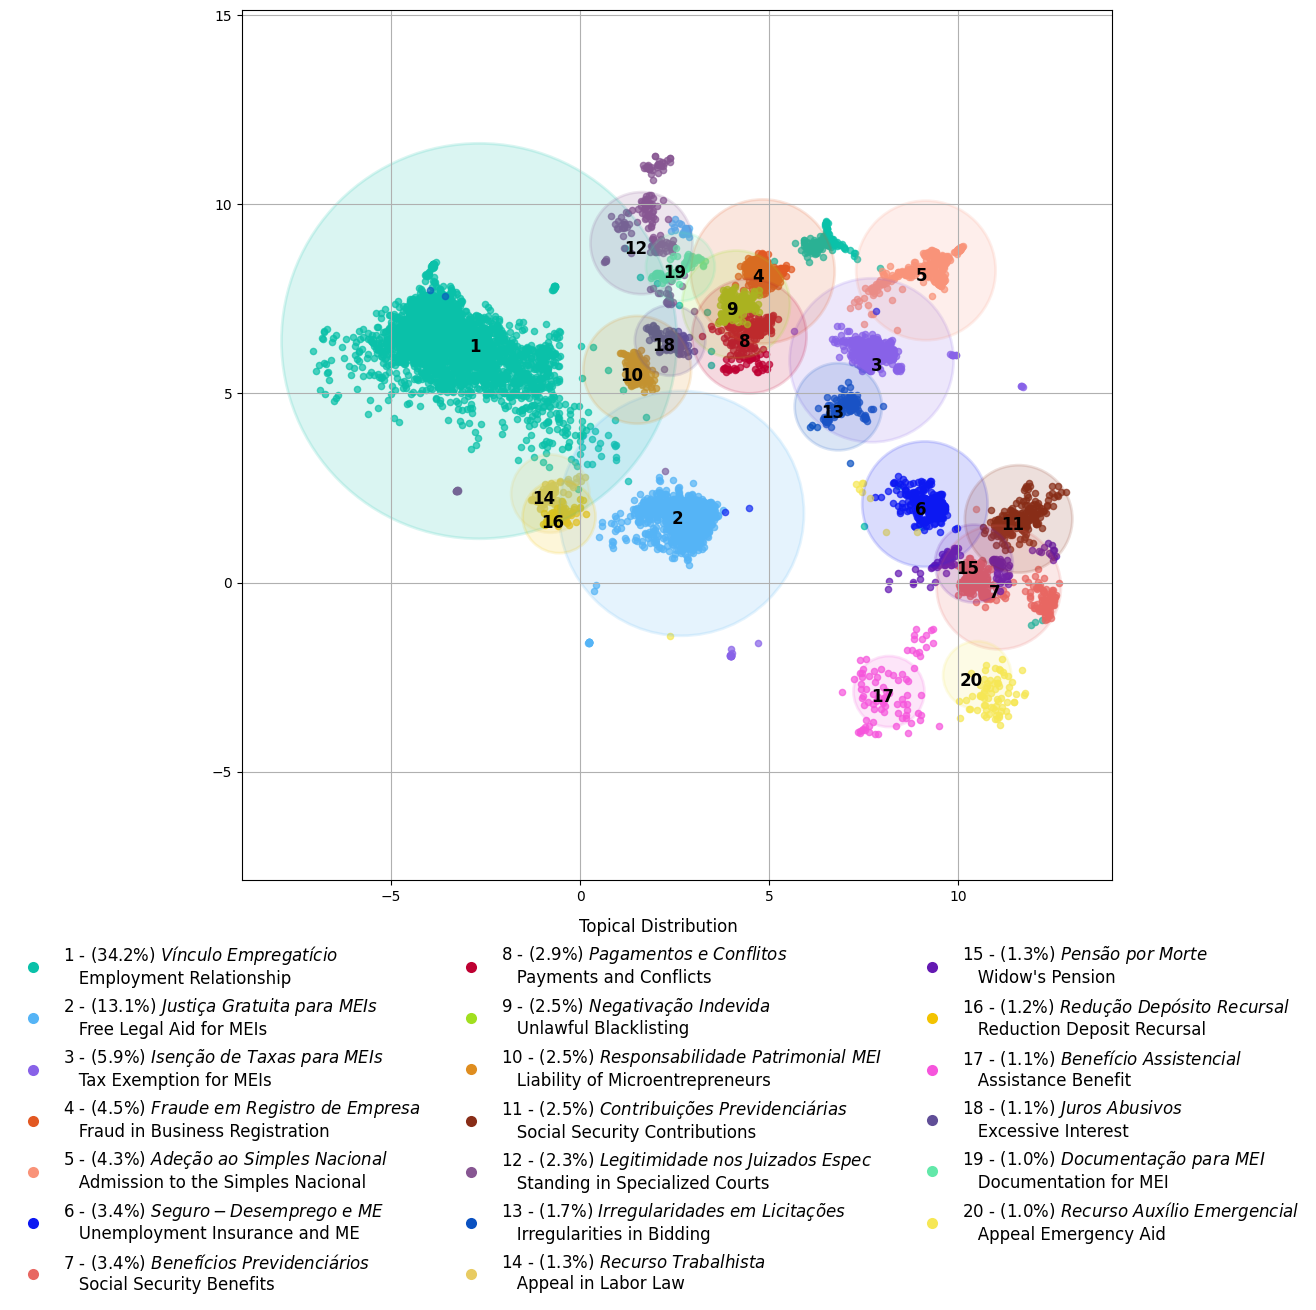

(<Figure size 1500x1500 with 1 Axes>, <AxesSubplot:>)

In [40]:
visualizar_grafico_cluster_from_df2_vertical(
    df,
    topic_names=topic_names,
    max_docs_per_topic=10000,
    top_n_topics=20,
    figsize=(15,15),
    alpha=0.7,
    zoom_margin=0.0,
    show_noise=False,
    title="",
    idioma = 'i+p' #i+p significa que a legenda deve ser gerada em ingles e portugues
    
)

C:\Users\Loreane\AppData\Local\Temp\ipykernel_11316\1380461089.py:87: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  ax.add_patch(Circle((cx, cy), raio, color=lut[topic], alpha=0.15, lw=2,
Looks like you are using an old matplotlib version.
               In some cases adjust_text might fail, if possible update
               matplotlib to version >=3.5.0


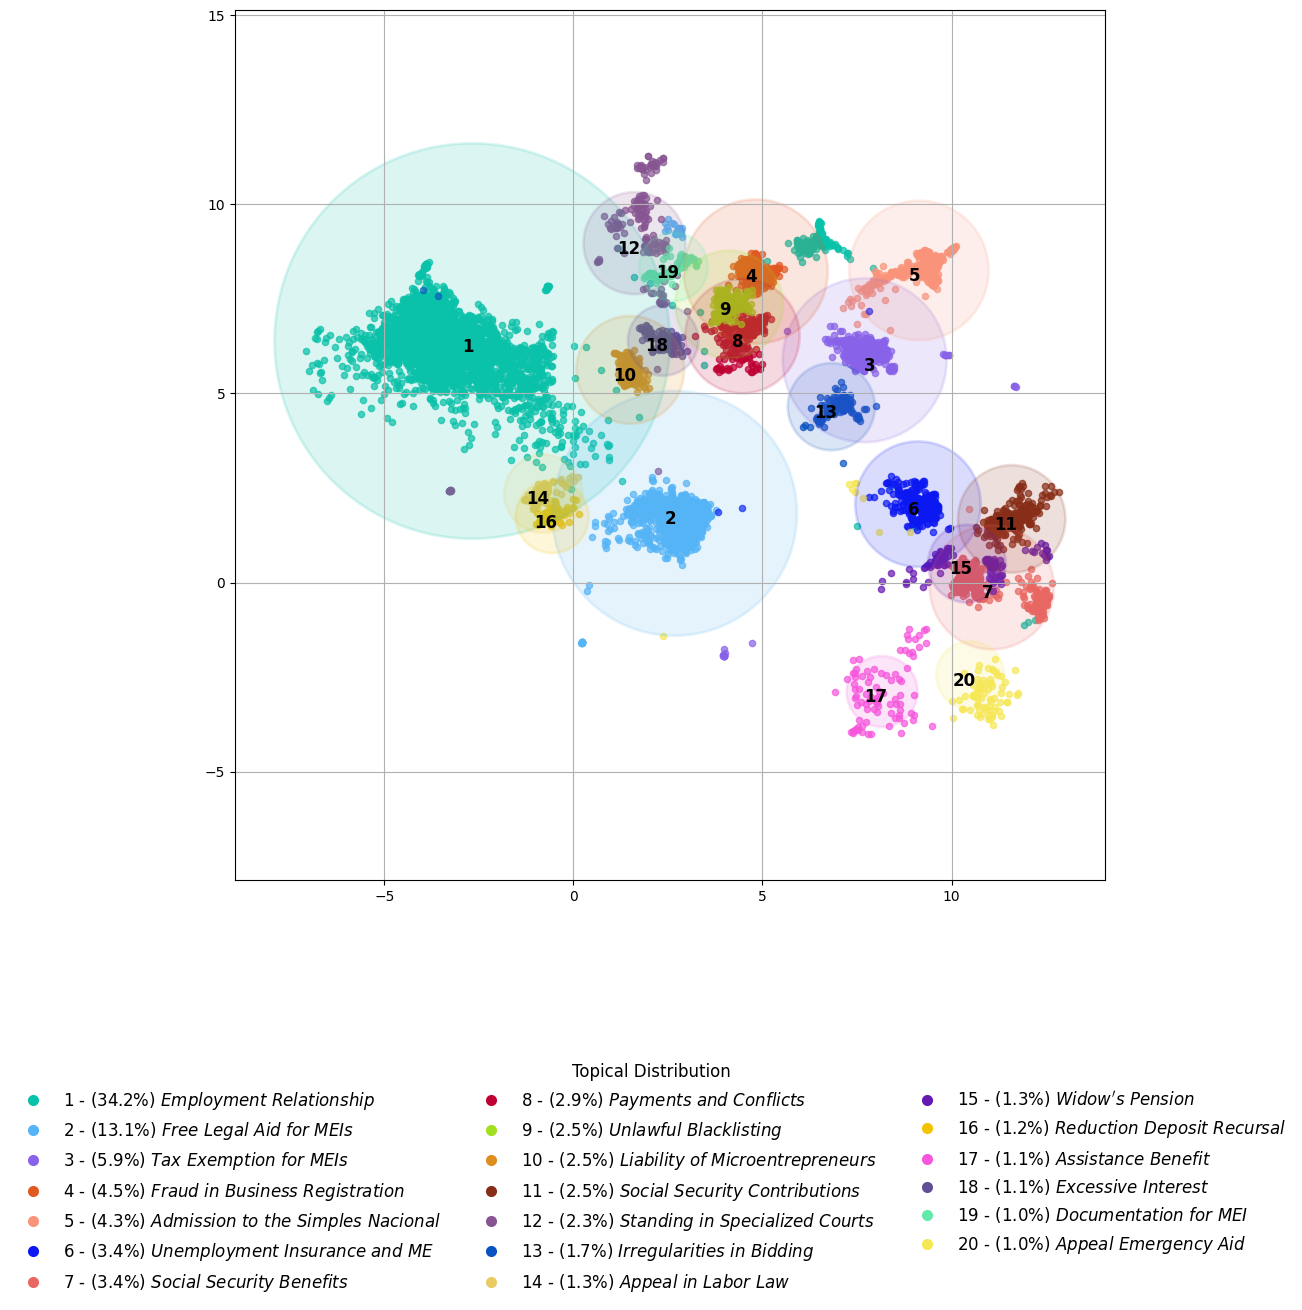

(<Figure size 1500x1500 with 1 Axes>, <AxesSubplot:>)

In [41]:
visualizar_grafico_cluster_from_df2_vertical(
    df,
    topic_names=topic_names,
    max_docs_per_topic=10000,
    top_n_topics=20,
    figsize=(15,15),
    alpha=0.7,
    zoom_margin=0.0,
    show_noise=False,
    title="",
    idioma = 'i' #i legenda deve ser gerada em ingles apenas
    
)

C:\Users\Loreane\AppData\Local\Temp\ipykernel_11316\1380461089.py:87: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  ax.add_patch(Circle((cx, cy), raio, color=lut[topic], alpha=0.15, lw=2,
Looks like you are using an old matplotlib version.
               In some cases adjust_text might fail, if possible update
               matplotlib to version >=3.5.0


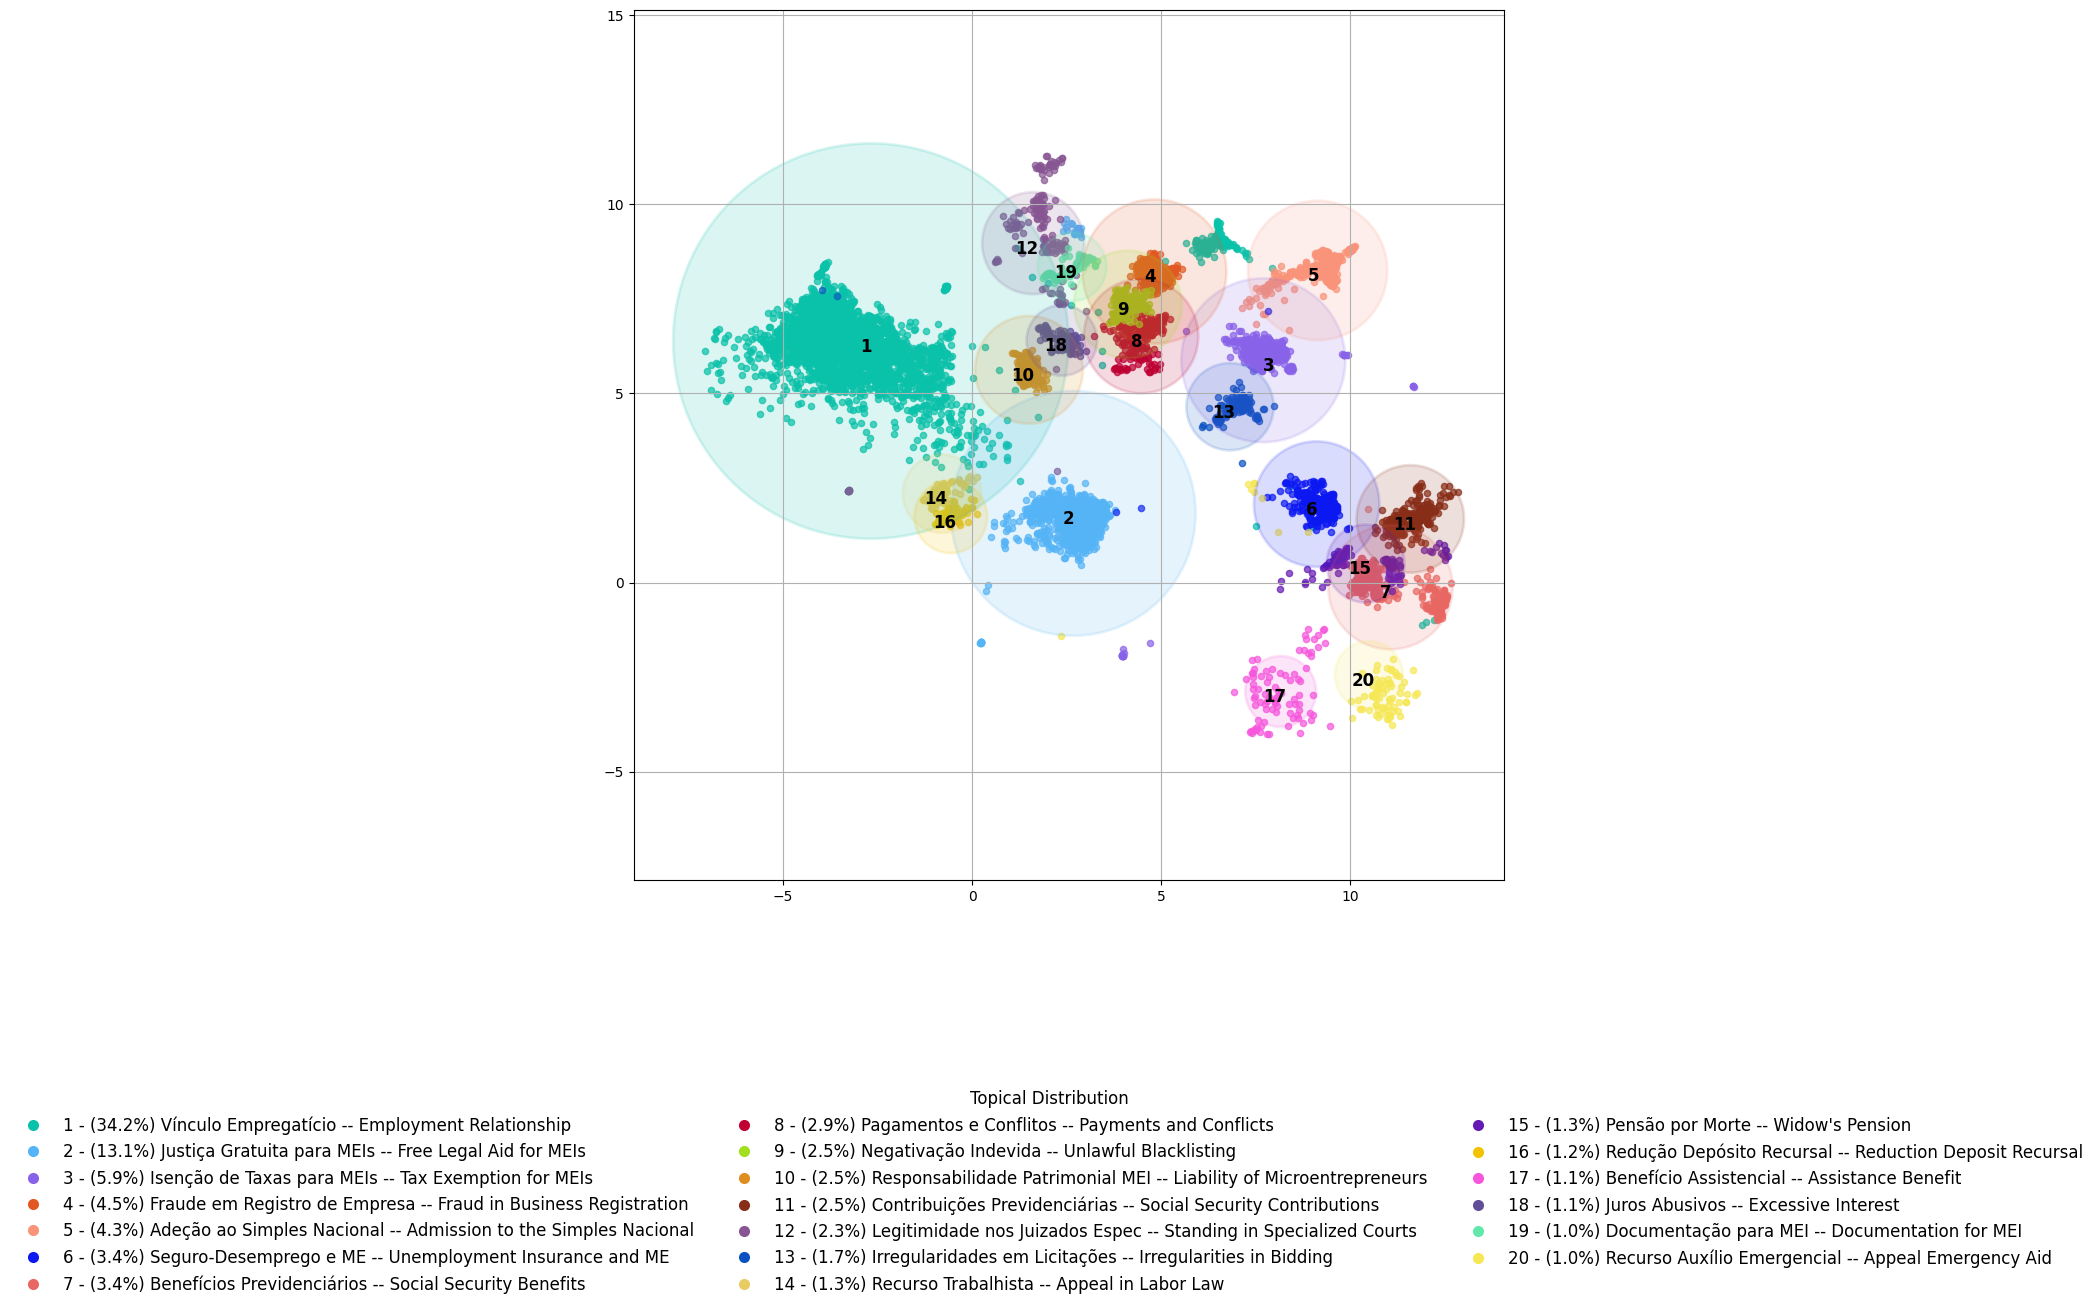

(<Figure size 1500x1500 with 1 Axes>, <AxesSubplot:>)

In [42]:
visualizar_grafico_cluster_from_df2_vertical(
    df,
    topic_names=topic_names,
    max_docs_per_topic=10000,
    top_n_topics=20,
    figsize=(15,15),
    alpha=0.7,
    zoom_margin=0.0,
    show_noise=False,
    title="",
    idioma = 'p' #i legenda deve ser gerada em ingles apenas
    
)

In [48]:
def visualizar_grafico_cluster_from_df2_horizontal(
    df,
    idioma,
    topic_names=None,
    max_docs_per_topic=None,   # não é mais usado (plota tudo)
    top_n_topics=None,
    figsize=(16, 16),
    alpha=0.7,
    zoom_margin=0.0,
    title="Distribuição dos Tópicos MEI (Legenda à Direita)",
    show_noise=False,
    xlim=None,
    ylim=None,
    square=True
):
    import matplotlib.gridspec as gridspec

    df = df.copy()
    df['corpus'] = df['descricao_caso'].fillna('') + ' ' + df['questoes_em_discussao'].fillna('')

    # --- Embeddings ---
    reduced_embeddings = np.vstack(df['coordenadas_umap'].apply(
        lambda x: np.array(x) if isinstance(x, (list, np.ndarray))
        else np.fromstring(str(x).strip('[]'), sep=',')
    ))

    col_topic = 'numero_topico_llm' if 'numero_topico_llm' in df.columns else 'numero_topico_LLM'
    topics = df[col_topic].astype(int).tolist()
    corpus = df['corpus'].tolist()

    # --- Mapa de cores do banco ---
    topic_colors = (
        df[[col_topic, 'cor_cluster']]
        .dropna(subset=['cor_cluster'])
        .astype({col_topic: int})
        .drop_duplicates(subset=[col_topic])
        .set_index(col_topic)['cor_cluster']
        .astype(str).str.strip().to_dict()
    )

    # --- Data prep ---
    df_plot = pd.DataFrame({
        'x': reduced_embeddings[:, 0],
        'y': reduced_embeddings[:, 1],
        'topic': topics,
        'text': corpus
    })

    if not show_noise:
        df_plot = df_plot[df_plot["topic"] != -1]

    if top_n_topics is not None:
        top_topics = [t for t, _ in Counter(df_plot["topic"]).most_common(top_n_topics)]
        df_plot = df_plot[df_plot["topic"].isin(top_topics)]

    # total após filtros
    qtd_total = len(df_plot)

    # tamanhos p/ bolhas
    topic_counts = df_plot["topic"].value_counts(normalize=True).to_dict()
    topic_sizes  = df_plot["topic"].value_counts().to_dict()
    sorted_topics = sorted(topic_counts.items(), key=lambda x: x[1], reverse=True)
    unique_topics = [t[0] for t in sorted_topics]

    # >>> NÃO há amostragem: usa todos os registros
    df_sampled = df_plot

    # --- Layout: gráfico 84%, legenda 16% ---
    fig = plt.figure(figsize=figsize)
    gs = gridspec.GridSpec(1, 2, width_ratios=[0.84, 0.16])
    ax = fig.add_subplot(gs[0])
    ax_legend = fig.add_subplot(gs[1])

    if square:
        ax.set_box_aspect(1)

    # Paleta de cores
    palette = sns.color_palette("tab20", len(unique_topics))
    lut = dict(zip(unique_topics, palette))
    if topic_colors:
        for t in unique_topics:
            if int(t) in topic_colors and str(topic_colors[int(t)]).strip():
                lut[t] = topic_colors[int(t)]

    texts = []
    legend_items = []
    _topic_names = topic_names or {}

    # --- Plot dos clusters ---
    # --- Plot dos clusters ---
    for i, topic in enumerate(unique_topics, start=1):
        data = df_sampled[df_sampled["topic"] == topic]
        raw_name = _topic_names.get(int(topic), f"Tópico {topic}")
        perc = df_plot[df_plot["topic"] == topic].shape[0] / max(1, qtd_total) * 100
    
        # Divide nome PT/EN se houver separador '--'
        if '--' in raw_name:
            pt_raw, en_raw = [s.strip() for s in raw_name.split('--', 1)]
        else:
            pt_raw, en_raw = raw_name.strip(), ""  # só PT disponível
    
        # Seleção por idioma:
        # 'p'   -> mostra só PT
        # 'i'   -> mostra só EN; se não houver EN, usa PT
        # 'i+p' -> mostra PT na linha 1 e EN (se houver) na linha 2
        if idioma == 'p':
            pt_name, en_name = pt_raw, ""
        elif idioma == 'i':
            pt_name, en_name = (en_raw or pt_raw), ""  # fallback para PT se não houver EN
        else:  # 'i+p' (default)
            pt_name, en_name = pt_raw, en_raw
    
        legend_items.append({
            "idx": i,
            "perc": perc,
            "pt": pt_name,
            "en": en_name,
            "color": lut[topic]
        })
    
        # pontos
        ax.scatter(data["x"], data["y"], s=20, alpha=alpha, color=lut[topic])
    
        # círculo de destaque
        cx, cy = data["x"].mean(), data["y"].mean()
        raio = np.sqrt(topic_sizes.get(topic, 1)) * 0.1
        ax.add_patch(Circle((cx, cy), raio, color=lut[topic], alpha=0.15, lw=2,
                            fill=True, edgecolor=lut[topic]))
    
        # índice no centroide
        t = ax.text(cx, cy, str(i), fontsize=12, weight='bold',
                    ha='center', va='center', color='black')
        texts.append(t)


    adjust_text(
        texts,
        only_move={'points': 'xy', 'text': 'xy'},
        expand_points=(1.8, 1.8),
        expand_text=(1.5, 1.5),
        force_text=(0.4, 0.4),
        force_points=(4, 5),
        precision=0.02,
        lim=300,
        ax=ax
    )

    # --- Configurações do gráfico ---
    ax.set_title(title, fontsize=14)
    ax.set_xlabel("")
    ax.set_ylabel("")
    #ax.grid(True)
    ax.set_axisbelow(True)
    ax.grid(True, color='lightgray', linestyle='--', linewidth=0.5)
    
    if xlim is not None:
        ax.set_xlim(xlim)
    if ylim is not None:
        ax.set_ylim(ylim)
    else:
        yr = df_sampled["y"].max() - df_sampled["y"].min()
        margin_y = max(1e-9, yr * 0.02)
        ax.set_ylim(df_sampled["y"].min() - margin_y, df_sampled["y"].max() + margin_y)

    ax.set_aspect('equal', adjustable='datalim')

    # --- Legenda à direita: sem linha, bolinha colada e duas linhas de texto ---
    ax_legend.axis("off")
    ax_legend.set_xlim(-0.04, 1)
    ax_legend.set_ylim(0, 1)

    y = 0.98
    for item in legend_items:
        # bolinha (colada ao texto)
        #ax_legend.scatter(0.00, y - 0.002, s=55, color=item["color"])

        # bolinha (mais afastada do texto e levemente mais acima)
        ax_legend.scatter(
            0.0,       # posição X (aumenta para afastar do texto)
            y + 0.006,   # posição Y (sobe um pouco)
            s=65,        # tamanho um pouco maior
            color=item["color"]
        )


        # linha 1: índice, % e nome PT (fonte maior)
        ax_legend.text(
            0.035, y + 0.006,
            f' {item["idx"]} - ({item["perc"]:.1f}%) {item["pt"]}',
            fontsize=17, va='center', ha='left', color='black'
        )

        # linha 2: nome EN (se houver), logo abaixo, um pouco menor
        if item["en"]:
            ax_legend.text(
                0.035, y - 0.020,
                item["en"],
                fontsize=17, va='center', ha='left', color='black'
            )
            y -= 0.050  # passo maior quando há segunda linha
        else:
            y -= 0.050  # passo normal


    # (Removido) linha divisória que sobrepunha as bolinhas

    plt.subplots_adjust(left=0.02, right=0.98, wspace=0.02)
    plt.show()
    return fig, ax


C:\Users\Loreane\AppData\Local\Temp\ipykernel_11316\3566553782.py:127: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  ax.add_patch(Circle((cx, cy), raio, color=lut[topic], alpha=0.15, lw=2,
Looks like you are using an old matplotlib version.
               In some cases adjust_text might fail, if possible update
               matplotlib to version >=3.5.0


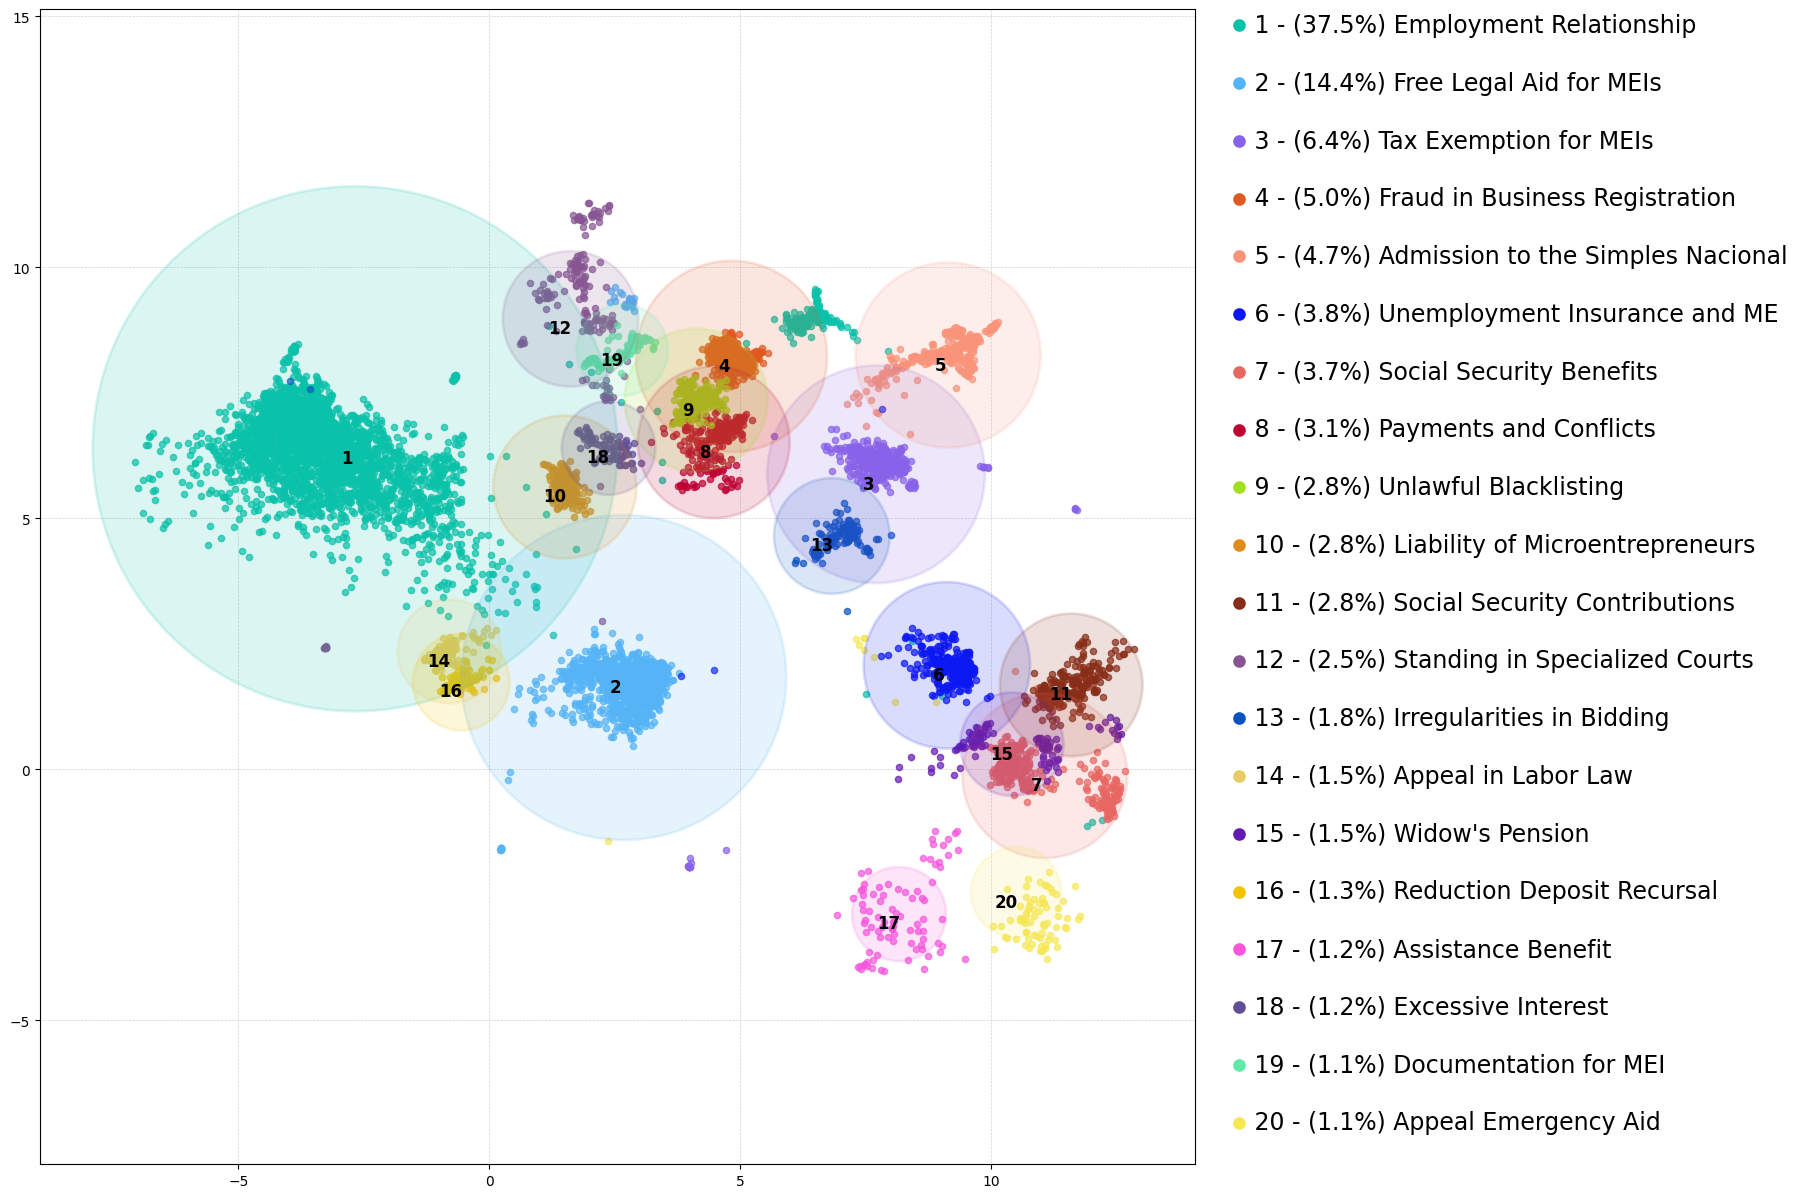

In [49]:
fig, ax = visualizar_grafico_cluster_from_df2_horizontal(
    df=df,
    topic_names=topic_names,     
    figsize=(15, 15),
    top_n_topics=20,   
    max_docs_per_topic=10000,    
    alpha=0.7,
    title="", idioma = 'i'
)


C:\Users\Loreane\AppData\Local\Temp\ipykernel_11316\3883919390.py:127: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  ax.add_patch(Circle((cx, cy), raio, color=lut[topic], alpha=0.15, lw=2,
Looks like you are using an old matplotlib version.
               In some cases adjust_text might fail, if possible update
               matplotlib to version >=3.5.0


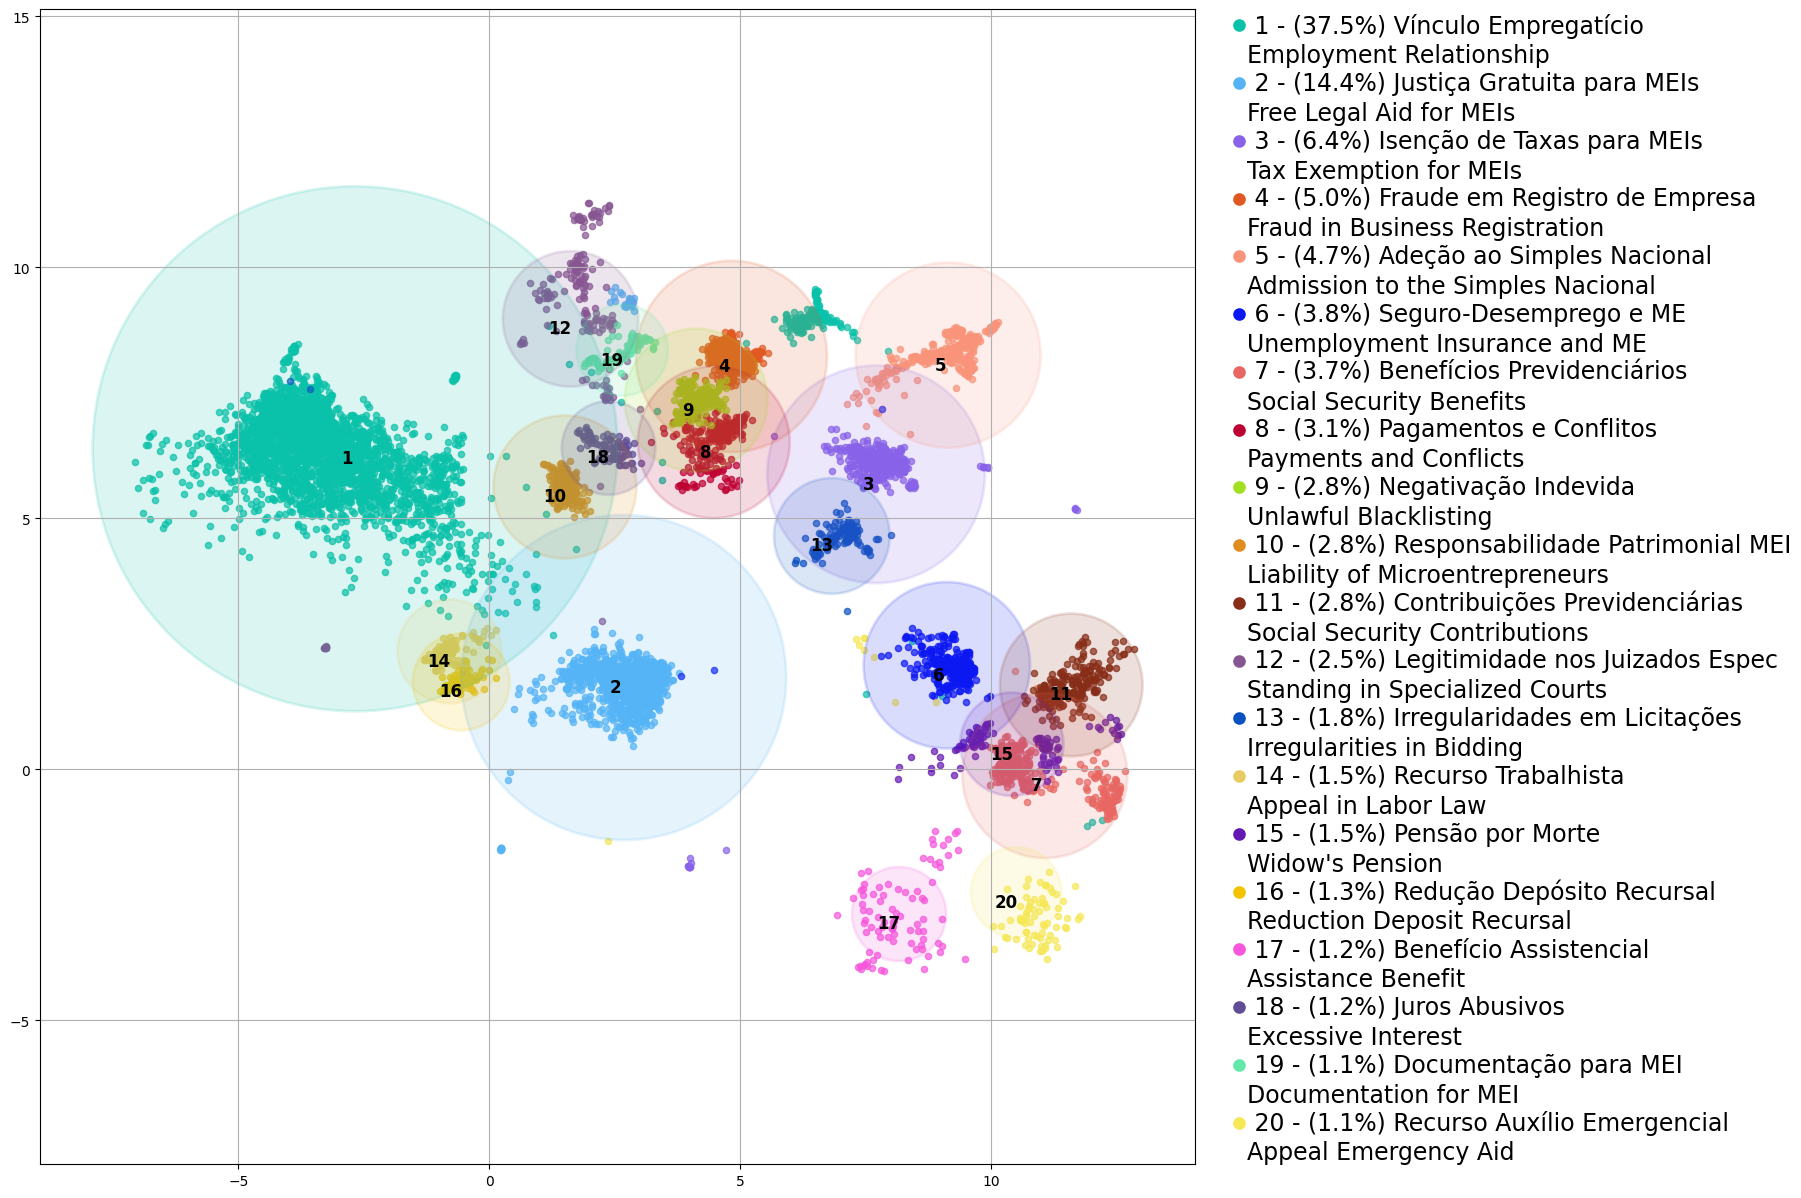

In [45]:
fig, ax = visualizar_grafico_cluster_from_df2_horizontal(
    df=df,
    topic_names=topic_names,     
    figsize=(15, 15),
    top_n_topics=20,   
    max_docs_per_topic=10000,    
    alpha=0.7,
    title="", idioma = 'i+p'
)
